In [17]:
# !pip install pandas
# jupyter nbconvert --to script get_tiled_data_from_tiff_hdf5_india.ipynb

In [18]:
import os
import json
import time
import pandas as pd
import datetime
import rasterio
from matplotlib import pyplot as plt
import numpy as np
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from os import path
import h5py
import geopy.distance
from rasterio.windows import Window, bounds as r_bounds
import random
import fnmatch

In [19]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

gauth = GoogleAuth()
# Try to load saved client credentials
gauth.LoadCredentialsFile("mycreds.txt")
if gauth.credentials is None:
    # Authenticate if they're not there
    gauth.LocalWebserverAuth()
elif gauth.access_token_expired:
    # Refresh them if expired
    gauth.Refresh()
else:
    # Initialize the saved creds
    gauth.Authorize()
# Save the current credentials to a file
gauth.SaveCredentialsFile("mycreds.txt")

drive = GoogleDrive(gauth)

In [20]:
local_testing_mode = True

# set params
tile_height, tile_length = (64, 64)
examples_per_save_file = 1000
composite_file_name = 'India_images_all_bands_scale_10_small_images'
# download_all_first = not local_testing_mode
download_all_first = False
offset_px = 20
offset_configs = [(0, 0)]
percent_neg_to_keep = 0.005

save_path = '/atlas/u/mliu356/data/kiln-scaling/bihar_tiles'
# composite_save_path = '/atlas/u/mliu356/data/kiln-scaling/composites/' # bangladesh, 2018-19
composite_save_path = '/atlas/u/mliu356/data/kiln-scaling/india_small_composites/' # new bangladesh

if local_testing_mode:
    save_path = '../data/tiles_testing5/'
    composite_save_path = '../data/india_small_composites/'

# resources
kilns = pd.read_csv("../data/india_bihar_kilns.csv")
all_bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B8', 'B9', 'B10', 'B11', 'B12']

print(kilns.head())

   S. No.   Longitude   Latitude Kiln Technology  Unnamed: 4 Unnamed: 5  \
0        1  85.015751  25.639469             ZZK         NaN        ZZK   
1        2  85.013481  25.639822             ZZK         NaN      FCBTK   
2        3  85.013028  25.640291             ZZK         NaN        NaN   
3        4  85.012540  25.640451             ZZK         NaN        NaN   
4        5  85.009052  25.640096             ZZK         NaN        NaN   

                        Unnamed: 6  
0                      ZigZag Kiln  
1  Fixed Chimney Bulls Trench Kiln  
2                              NaN  
3                              NaN  
4                              NaN  


In [21]:
def mkdirs(names):
    for name in names:
        if not os.path.exists(name):
            os.makedirs(name)
mkdirs([save_path, composite_save_path])

In [22]:
file_list = drive.ListFile({'q': "title contains '" + composite_file_name + "'"}).GetList()
print("Found " + str(len(file_list)) + " files")
file_list = sorted(file_list, key=lambda file: file['title'])
for file in file_list[:5]:
  print('title: %s, id: %s' % (file['title'], file['id']))

Found 2401 files
title: India_images_all_bands_scale_10_small_images-0000000000-0000000000.tif, id: 1wbaM2PG-VEVldkjYF1P3gIi7jCoy8RfN
title: India_images_all_bands_scale_10_small_images-0000000000-0000006656.tif, id: 1k1EnXKPpUiC8-b_3j6QITz5eIPPOajoA
title: India_images_all_bands_scale_10_small_images-0000000000-0000013312.tif, id: 18G-ZZvP5_PxP7v7upGrWvNBuGGcrkJLN
title: India_images_all_bands_scale_10_small_images-0000000000-0000019968.tif, id: 1unmRZ4wsnnYuVXo4Hx33Ltl-pljq5SM6
title: India_images_all_bands_scale_10_small_images-0000000000-0000026624.tif, id: 1F5yzhNoRfOHlE998G85GXKmiQj1ENv7-


In [23]:
# calculate image grid
print(file_list[0]['title'].split(".")[0])
first_x_coord = file_list[0]['title'].split(".")[0].split("-")[1]
first_y_coord = file_list[0]['title'].split(".")[0].split("-")[2]
num_image_cols = len([x for x in file_list if x['title'].split(".")[0].split("-")[1] == first_x_coord])
num_image_rows = len([x for x in file_list if x['title'].split(".")[0].split("-")[2] == first_y_coord])
print("Number of image grid columns:", num_image_cols)
print("Number of image grid rows:", num_image_rows)

India_images_all_bands_scale_10_small_images-0000000000-0000000000
Number of image grid columns: 49
Number of image grid rows: 49


In [24]:
coords = []
with open("../data/india_district.geojson", "r") as district_geojson:
    dist_dict = json.load(district_geojson)["features"]
for obj in dist_dict:
    name = obj['properties']['NAME_1']
    if name == "Bihar":
        coords = obj['geometry']["coordinates"]
flat_coords = []
for sublist in coords:
    for coord in sublist:
        flat_coords.append(coord)
            
flat_coords += [flat_coords[0]]
bihar_geo = Polygon(flat_coords)
# print(bihar_geo)
print(pretty_bounds(bihar_geo.bounds))

[[85.06133270263672, 25.485349655151424], [85.63044738769543, 25.485349655151424], [85.63044738769543, 26.016477584838867], [85.06133270263672, 26.016477584838867], [85.06133270263672, 25.485349655151424]]


In [25]:
# optional pre-download all files

if download_all_first:
    for file in file_list:
#         start_time = time.time()
        composite_file_path = composite_save_path + file['title']
        if path.exists(composite_file_path):
            print("File already downloaded.", composite_file_path)
        else:
            print("Downloading file...")
            # download the file
            download_file = drive.CreateFile({'id': file['id']})
            file.GetContentFile(composite_file_path)
#             print("Finished file in " + str(time.time() - start_time))
    print("Done downloading all files.")

In [26]:
def get_tile_info_from_px(dataset, px_row, px_col, has_kiln):
    global num_tiles_dropped
    global pos_examples_data, pos_examples_bounds
    global test_ex_data, test_ex_bounds
    
    window = Window(px_col, px_row, tile_length, tile_height)
    bands = dataset.read(window=window)
    bounds = list(r_bounds(window, dataset.transform))
    tile_geo = Polygon([[bounds[0], bounds[2]], [bounds[0], bounds[3]], [bounds[1], bounds[3]], [bounds[1], bounds[2]], [bounds[0], bounds[2]]])
    
    if has_kiln or bihar_geo.intersects(tile_geo):
        return bands, bounds
    else:
        return None, None
    
def get_tile_has_kiln(dataset, px_row, px_col):
    window = Window(px_col, px_row, tile_length, tile_height)
    bounds = list(r_bounds(window, dataset.transform))
    kilns_in_image = kilns.loc[(kilns['Latitude'] >= bounds[1]) & (kilns['Latitude'] <= bounds[3]) 
        & (kilns['Longitude'] >= bounds[0]) & (kilns['Longitude'] <= bounds[2])]

    return len(kilns_in_image) >= 1

In [27]:
def save_current_file(save_index, counter):
    filename = save_path + "examples_" + str(save_index) + ".hdf5"
    print("Saving file", filename)
    f = h5py.File(filename, 'w')
    bounds_dset = f.create_dataset("bounds", data=tile_bounds[:counter])
    examples_dset = f.create_dataset("images", data=examples[:counter])
    labels_dset = f.create_dataset("labels", data=labels[:counter])
    indices_dset = f.create_dataset("indices", data=tile_indices[:counter])
    f.close()
    return save_index + 1, 0

def add_example(ex_data, ex_bounds, t_global_indices, save_index, counter, is_positive):
    tile_bounds[counter] = ex_bounds
    examples[counter] = ex_data
    labels[counter] = 1 if is_positive else -1
    tile_indices[counter] = t_global_indices
    new_counter = counter + 1
    
    if new_counter == examples_per_save_file:
        return save_current_file(save_index, counter)
    return save_index, new_counter

In [28]:
## testing & visualization methods

# image is a single example of shape (13, 64, 64)
def visualize_tile(image, indices=[3, 2, 1]):
    row_idx = np.array(indices)
    X = np.transpose(image[row_idx], (1, 2, 0))
    X *= 1 / np.max(X)
    print(X.shape)
    plt.imshow(X)
    
def pretty_bounds(bounds):
    return [[bounds[0], bounds[1]], [bounds[2], bounds[1]], [bounds[2], bounds[3]], [bounds[0], bounds[3]], [bounds[0], bounds[1]]]

In [29]:
## testing variables
num_tiles_dropped = 0
pos_examples_data = []
pos_examples_bounds = []
test_ex_data = []
test_ex_indices = []
test_ex_bounds = []

save_index, counter = 0, 0

tile_bounds = np.zeros([examples_per_save_file, 4]) # [left, bottom, right, top]
examples = np.zeros([examples_per_save_file, len(all_bands), tile_height, tile_length])
labels = np.zeros([examples_per_save_file, 1])
tile_indices = np.zeros([examples_per_save_file, 3]) # [row, col, offset_index]

last_file_completed = None

test_bounds = []
test_ex = []
test_labels = []
test_indices = []

In [30]:
# print(composite_file_path)
# dataset = rasterio.open(composite_file_path)
# # bands = dataset.read()
# print(dataset.count)
# print(bands.shape)

# dataset2 = rasterio.open('../data/composites/bangladesh_all_bands_final-0000000000-0000000000.tif')
# print(dataset2.count)
# # bands2 = dataset2.read()
# print(bands2.shape)

In [31]:
if local_testing_mode:
    file_list = file_list[10:]

In [32]:
std_tile_rows, std_tile_cols = None, None
    
total_start_time = time.time()
for index, file in enumerate(file_list):
    if (last_file_completed == None or file['title'] > last_file_completed):
        file_start_time = time.time()
        print("Starting file " + file['title'])

        # get composite image indices
        c_row = int(index / num_image_cols)
        c_col = index % num_image_cols

        composite_file_path = composite_save_path + file['title']
        if not path.exists(composite_file_path):
            print("Downloading file...")
            # download the file
            download_file = drive.CreateFile({'id': file['id']})
            file.GetContentFile(composite_file_path)
        dataset = rasterio.open(composite_file_path)
        image_geo = Polygon(pretty_bounds(dataset.bounds))
#         print("image bounds", pretty_bounds(dataset.bounds))
    
        if bihar_geo.intersects(image_geo):
            for offset_index, offset_config in enumerate(offset_configs):
                num_rows = int((dataset.height - offset_config[0]) / tile_height)
                num_cols = int((dataset.width - offset_config[1]) / tile_length)

                if std_tile_rows is None:
                    std_tile_rows = num_rows
                    std_tile_cols = num_cols

                # first pass to calculate kiln_tiles
                kiln_tiles = []
                for tile_idx_row in range(0, num_rows):
                    px_row = tile_idx_row * tile_height + offset_config[0]
                    for tile_idx_col in range(0, num_cols):
                        px_col = tile_idx_col * tile_length + offset_config[1]
                        if get_tile_has_kiln(dataset, px_row, px_col):
                            kiln_tiles += [(tile_idx_row, tile_idx_col)]

                # second pass to calculate and save data
                for tile_idx_row in range(0, num_rows):
                    px_row = tile_idx_row * tile_height + offset_config[0]
                    for tile_idx_col in range(0, num_cols):
                        px_col = tile_idx_col * tile_length + offset_config[1]
                        tile_has_kiln = (tile_idx_row, tile_idx_col) in kiln_tiles
                        t_data, t_bounds = get_tile_info_from_px(dataset, px_row, px_col, tile_has_kiln)

                        # save data only if:
                        # (1) t_data is not None AND
                        # (2a) tile contains kiln OR
                        # (2b) tile is in the random negative sample (percent_neg_to_keep)
                        if t_data is not None and not np.isnan(np.sum(t_data)) and (tile_has_kiln or random.random() > percent_neg_to_keep):
                            t_global_row = c_row * std_tile_rows + tile_idx_row
                            t_global_col = c_col * std_tile_cols + tile_idx_col
                            t_global_indices = [t_global_row, t_global_col, offset_index]
                            
#                             print(".")

                            save_index, counter = add_example(t_data, t_bounds, t_global_indices, save_index, counter, tile_has_kiln)
                            test_bounds += [t_bounds]
                            test_ex += [t_data]
                            test_labels += [tile_has_kiln]
                            test_indices += [t_global_indices]

        last_file_completed = file['title']
    
    # handle leftovers in a final file
    if index == len(file_list) - 1:
        save_current_file(save_index, counter)

#     print("Total tiles dropped (outside country):", num_tiles_dropped)
#     print("Total tiles kept:", str(num_rows * num_cols * len(offset_configs) - num_tiles_dropped))
    num_tiles_dropped = 0
    print("Finished file in", time.time() - file_start_time, "\n")
print("Finished " + str(len(file_list)) + " files in: " + str(time.time() - total_start_time))

Starting file India_images_all_bands_scale_10_small_images-0000000000-0000066560.tif
Finished file in 3.1479549407958984 

Starting file India_images_all_bands_scale_10_small_images-0000000000-0000073216.tif
Finished file in 2.9322750568389893 

Starting file India_images_all_bands_scale_10_small_images-0000000000-0000079872.tif
Finished file in 3.3051700592041016 

Starting file India_images_all_bands_scale_10_small_images-0000000000-0000086528.tif
Finished file in 3.0774660110473633 

Starting file India_images_all_bands_scale_10_small_images-0000000000-0000093184.tif
Finished file in 2.626556873321533 

Starting file India_images_all_bands_scale_10_small_images-0000000000-0000099840.tif
Finished file in 3.1303038597106934 

Starting file India_images_all_bands_scale_10_small_images-0000000000-0000106496.tif
Finished file in 4.8046417236328125 

Starting file India_images_all_bands_scale_10_small_images-0000000000-0000113152.tif


KeyboardInterrupt: 

## Test hdf5 file data format & visualizations

In [18]:
# import h5py
# import numpy as np
# from matplotlib import pyplot as plt
# f = h5py.File('/atlas/u/mhelabd/data/kiln-scaling/balanced_tiles/final_tiles_drop_neighbors.hdf5')
# print(len(f['images']))
# print(f['images'][0])
# print(visualize_tile(f['images'][0]))

In [22]:
print(pretty_bounds([68.14332284439772, 35.489741929709936, 68.14907206221608, 35.4954911475283]))

[[68.14332284439772, 35.489741929709936], [68.14907206221608, 35.489741929709936], [68.14907206221608, 35.4954911475283], [68.14332284439772, 35.4954911475283], [68.14332284439772, 35.489741929709936]]


8026
(13, 64, 64)
[[77.56054163087948, 34.89757249441835], [77.56629084869785, 34.89757249441835], [77.56629084869785, 34.90332171223671], [77.56054163087948, 34.90332171223671], [77.56054163087948, 34.89757249441835]]
False
(64, 64, 3)
[103, 1638, 0]


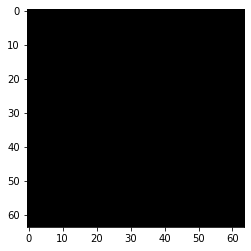

In [40]:
print(len(test_ex))
vis_index = 8000
print(test_ex[vis_index].shape)
print(pretty_bounds(test_bounds[vis_index]))
print(test_labels[vis_index])

visualize_tile(test_ex[vis_index])
print(test_indices[vis_index])

In [27]:
# print("Examples w/ kilns:", np.where(labels==1.0)[0])
# index = 4321
# print("label:", y[index])
# vis_X = X[index]
# vis_X *= 1 / np.max(vis_X)
# print(vis_X.shape)
# plt.imshow(vis_X)

Examples w/ kilns: [40 41 42]
